# Cell Segmentation with Tuned U-Net
## Methodology
This notebook demonstrates the task of segmenting cells in biomedical images by leveraging a tuned U-Net architecture, an advanced deep learning model renowned for its efficacy in image segmentation tasks.

### Overview:
1. **Dataset Download**: Step-by-step guidance on downloading the dataset from Kaggle.
2. **Data Preprocessing**: Utilizing 'data_loader.py' to efficiently load and preprocess the dataset for optimal model training.
3. **Model Building and Hyperparameter Tuning**: Defining the U-Net model structure and employing Keras Tuner to fine-tune the hyperparameters, enhancing the model's performance.
4. **Evaluation**: Assessing the model's performance.
5. **Visualization**: Using `utils.py` to visualize the results.

This project is designed to offer a detailed and practical approach to cell segmentation, showcasing the power of hyperparameter tuning in improving model outcomes. It serves as a valuable resource for researchers and practitioners in biomedical image analysis, providing a robust foundation for further exploration and innovation in the field.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Cell-Segmentation-with-UNet/Scripts')

In [4]:
# Install Keras Tuner
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


## Imports

In [5]:
# Import necessary libraries
import tensorflow as tf
import kerastuner as kt
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.transform import resize
# Import custom scripts
from data_loader import unzip_to_original_subfolders, get_data_paths, preprocess_image, preprocess_mask, load_dataset
from utils import display_sample_grid

<ipython-input-5-01a433d58450>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Dataset Download Instructions


The dataset used in this project is from the 2018 Data Science Bowl, available on Kaggle. Follow these steps to download and prepare the dataset:

1. Go to [Kaggle Dataset Link](https://www.kaggle.com/c/data-science-bowl-2018/data).
2. Download the dataset to your local machine.
3. Unzip the dataset into the `data` directory of this project.

Alternatively, you can use the provided script in the `Scripts` directory to automate this process.


In [6]:
# Importing necessary libraries for file upload in Google Colab
from google.colab import files

# Prompting for file upload (e.g., kaggle.json for API authentication) in Google Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahdihabibi","key":"9c649f099a1c0bcb7f3ca5b2fe7403a9"}'}

In [7]:
# Setup for Kaggle API and move the uploaded kaggle.json file into the Kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the file

# Download the 2018 Data Science Bowl dataset
!kaggle competitions download -c data-science-bowl-2018

100% 358M/358M [00:20<00:00, 18.3MB/s]
100% 358M/358M [00:20<00:00, 18.5MB/s]


In [8]:
# Unzip the dataset
!unzip -q data-science-bowl-2018.zip -d dsb2018

# Call the function on 'dsb2018' directory
unzip_to_original_subfolders('dsb2018')

## Load and Preprocess the Dataset

In [9]:
# Define image dimensions and path to training data
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 128, 128, 3
TRAIN_PATH = '/content/dsb2018/stage1_train/'

# Load the dataset
X_train, Y_train = load_dataset(TRAIN_PATH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

## Display Random Samples

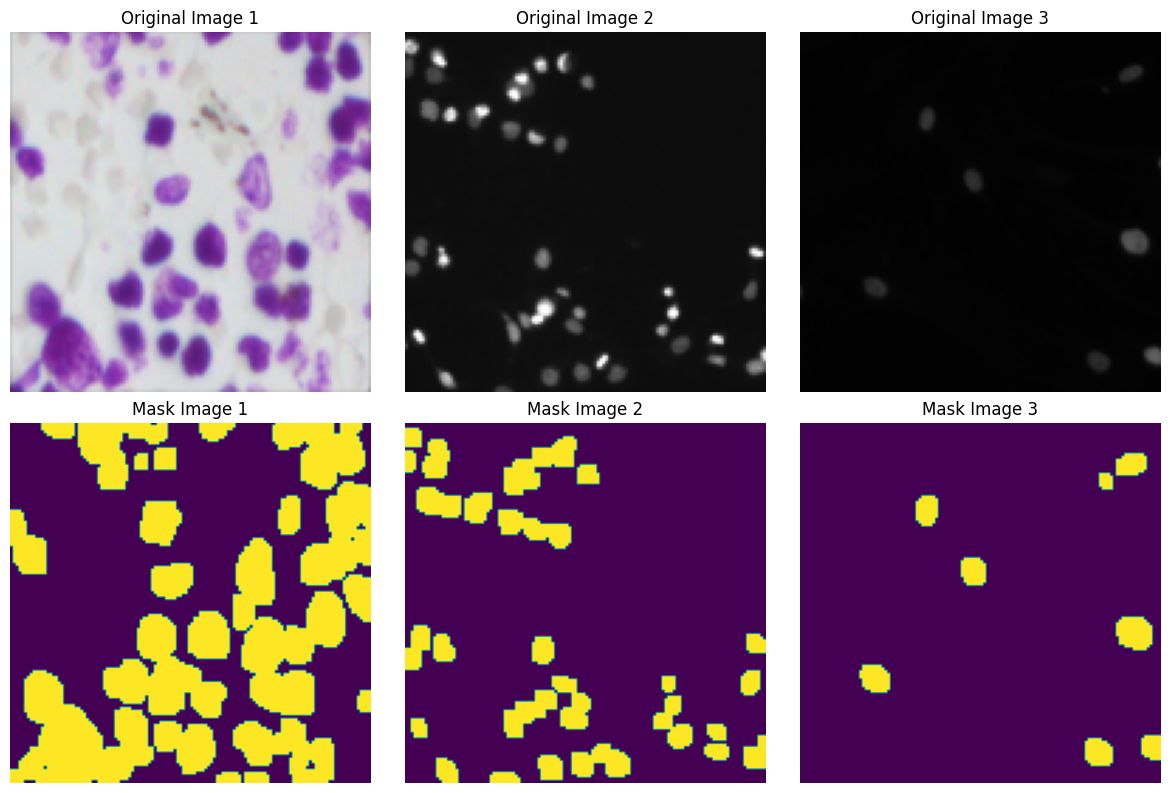

In [10]:
display_sample_grid(X_train, Y_train, num_samples=3)

#**Build U-Net Model:**
U-Net is a convolutional neural network architecture designed for biomedical image segmentation.
It consists of a contracting path (encoder) and an expansive path (decoder) with skip connections.

In [63]:
def convolutional_block(inputs, filters, dropout_rate=0.1):
    """
    Define a convolutional block with two convolutional layers and dropout.

    Parameters:
    - inputs: Input tensor.
    - filters: Number of filters for the convolutional layers.
    - dropout_rate: Dropout rate for regularization.

    Returns:
    - conv: Output tensor of the convolutional block.
    """
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv = tf.keras.layers.Dropout(dropout_rate)(conv)
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    return conv

def build_unet_tuned(hp):
    """
    Build a U-Net model with tunable hyperparameters for convolutional layers and dropout rates.

    The U-Net model is constructed using a series of convolutional blocks in both contraction (encoder)
    and expansive (decoder) paths, with hyperparameters defining the number of filters and dropout rates at each block.

    Parameters:
    - hp: Hyperparameters object from Keras Tuner for defining the hyperparameter search space.

    Returns:
    - model: Constructed U-Net model with the defined architecture and compiled with an optimizer, loss function, and metrics.
    """
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
    input_layer = tf.keras.layers.Input(input_shape)

    # Normalize inputs to a range of [0, 1]
    scaled_input = tf.keras.layers.Lambda(lambda x: x / 255)(input_layer)

    # Begin defining U-Net architecture using hyperparameters
    # Define the number of filters and dropout rate using hyperparameters
    hp_filters_0  = hp.Int('filters_0', min_value=16, max_value=256, step=16)
    hp_dropout_0 = hp.Float('dropout_0', min_value=0.0, max_value=0.5, default=0.1)

    hp_filters_1  = hp.Int('filters_1', min_value=16, max_value=256, step=16)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.1)

    hp_filters_2  = hp.Int('filters_2', min_value=16, max_value=256, step=16)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.1)

    hp_filters_3  = hp.Int('filters_3', min_value=16, max_value=256, step=16)
    hp_dropout_3 = hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.1)

    hp_filters_4  = hp.Int('filters_4', min_value=16, max_value=256, step=16)
    hp_dropout_4 = hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.1)


    # Contraction Path (Encoder):
    # Each block in the contraction path consists of two convolutional layers followed by max pooling
    conv1 = convolutional_block(scaled_input, hp_filters_0, hp_dropout_0)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = convolutional_block(pool1, hp_filters_1, hp_dropout_1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = convolutional_block(pool2, hp_filters_2, hp_dropout_2)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = convolutional_block(pool3, hp_filters_3, hp_dropout_3)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

    # Bottleneck layer
    conv5 = convolutional_block(pool4, hp_filters_4, hp_dropout_4)

    # Expansive path (Decoder):
    # Each block in the expansive path consists of an up-convolution followed by concatenation with the corresponding contraction block
    up6 = tf.keras.layers.Conv2DTranspose(hp_filters_3, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv4])
    conv6 = convolutional_block(up6, hp_filters_3, hp_dropout_3)

    up7 = tf.keras.layers.Conv2DTranspose(hp_filters_2, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv3])
    conv7 = convolutional_block(up7, hp_filters_2, hp_dropout_2)

    up8 = tf.keras.layers.Conv2DTranspose(hp_filters_1, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = tf.keras.layers.concatenate([up8, conv2])
    conv8 = convolutional_block(up8, hp_filters_1, hp_dropout_1)

    up9 = tf.keras.layers.Conv2DTranspose(hp_filters_0, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = tf.keras.layers.concatenate([up9, conv1])
    conv9 = convolutional_block(up9, hp_filters_0, hp_dropout_0)

    # Output layer with a single neuron and sigmoid activation to output a probability map for segmentation
    output_layer = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # Compile the model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the Tuner and Perform Hyperparameter Search
Hyperband is a multi-armed bandit-based approach that uses adaptive resource allocation and early-stopping to quickly converge on high-performing models.

In [14]:
tuner = kt.Hyperband(
    build_unet_tuned,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_results',
    project_name='unet_tuning'
)

In [15]:
# Early stopping to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
# Execute the hyperparameter search
tuner.search(X_train, Y_train, epochs=25, validation_split=0.1, callbacks=[stop_early])

Trial 30 Complete [00h 00m 57s]
val_accuracy: 0.9606250524520874

Best val_accuracy So Far: 0.9606250524520874
Total elapsed time: 00h 39m 40s


In [17]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [19]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Display the structure of the U-Net model
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 128, 128, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 48)         1344      ['lambda_1[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 48)         0         ['conv2d_19[0][0]']           
                                                                                            

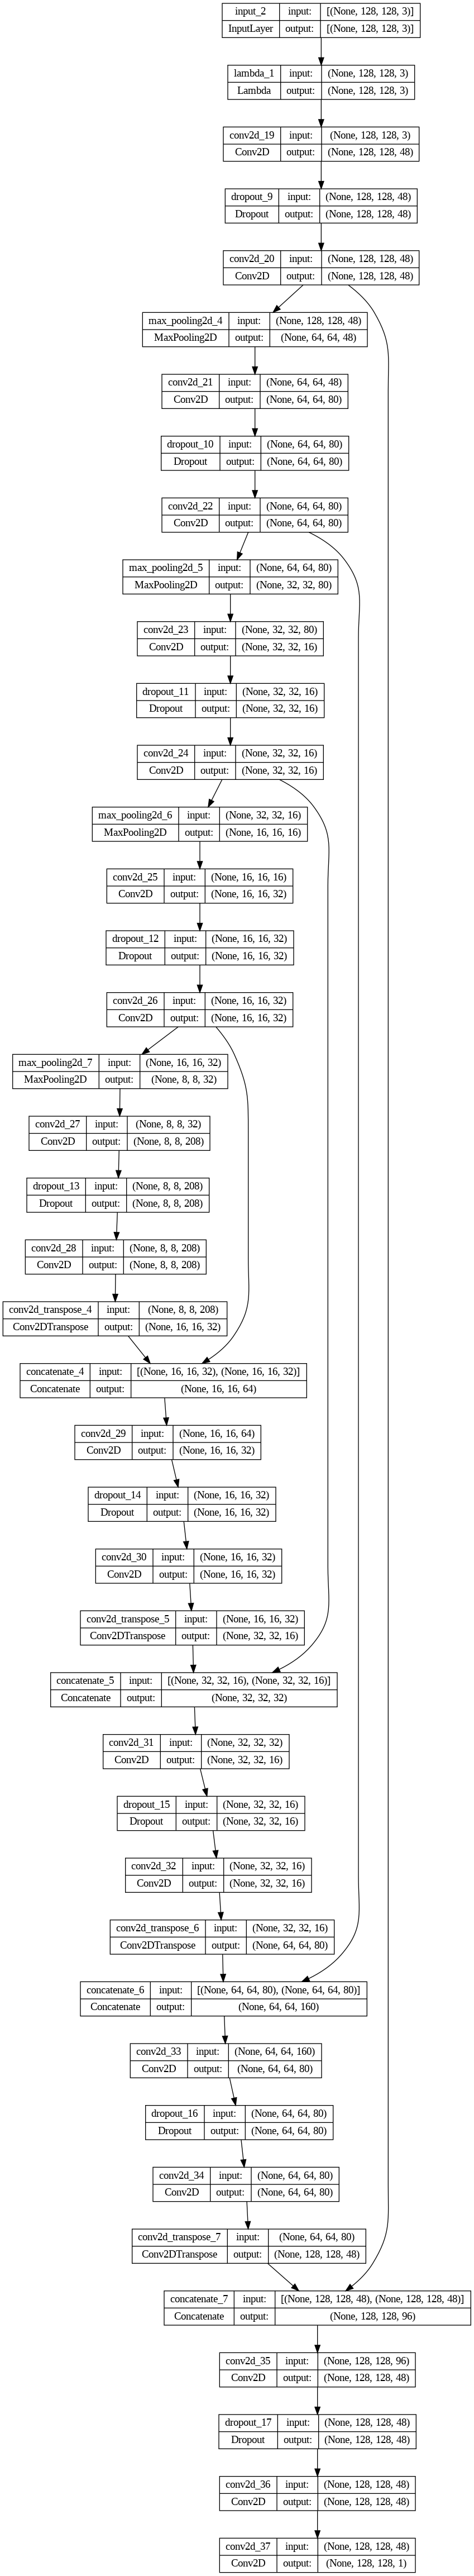

In [20]:
# Generate a plot of the U-Net model's architecture
tf.keras.utils.plot_model(best_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

#Define callbacks to have more control during model training

##**Model Checkpoint**
*   Callback to save the model with the best validation loss
*   This ensures that we always save the model in its best-performing state on the validation data

In [39]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_UNet_nuclei_tuned.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'    # The target, 'val_loss', should be minimized
)

# Early Stopping


*   Callback to stop training when the validation loss stops improving
*   This helps in preventing overfitting and reduces unnecessary training time




In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min',
    verbose=1
)

# TensorBoard Logging


*   Callback to log training progress for visualization in TensorBoard
*   It provides great visualization tools which help in monitoring the training process


In [41]:
tensorboard_logger = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1       # Log histogram visualizations every 1 epoch
)

# Callbacks List


*   List of callbacks to be used in model training
*   Including model checkpointing, early stopping, and TensorBoard logging

In [42]:
callbacks_list = [model_checkpoint, early_stopping, tensorboard_logger]

# Rebuild the Model with the Best Hyperparameters


In [43]:
# Build the model with the best hyperparameters
best_model_tuned = tuner.hypermodel.build(best_hps)

# Fit the best model
results = best_model_tuned.fit(
    x=X_train,
    y=Y_train,
    batch_size=16,
    epochs=25,
    validation_split=0.1,
    callbacks=callbacks_list
)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7555
Epoch 1: val_loss improved from inf to 0.43862, saving model to model_UNet_nuclei_tuned.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 18s 232ms/step - loss: 0.6337 - accuracy: 0.7555 - val_loss: 0.4386 - val_accuracy: 0.7846
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8469
Epoch 2: val_loss improved from 0.43862 to 0.18982, saving model to model_UNet_nuclei_tuned.h5
38/38 [==============================] - 5s 138ms/step - loss: 0.3299 - accuracy: 0.8469 - val_loss: 0.1898 - val_accuracy: 0.9193
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9359
Epoch 3: val_loss improved from 0.18982 to 0.15876, saving model to model_UNet_nuclei_tuned.h5
38/38 [==============================] - 5s 143ms/step - loss: 0.1693 - accuracy: 0.9359 - val_loss: 0.1588 - val_accuracy: 0.9382
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9503
Epoch 4: val_loss improved from 0.15876 to 0.12092, saving model to model_UNet_nuclei_tuned.h5
38/38 [==============================] 

## Test Data Preparation and Loading

This section is dedicated to preparing and loading the test dataset. It involves locating the test image files, preprocessing them to match the format used during training, and loading them into an array for evaluation.


In [44]:
# Define the path to the test dataset
TEST_PATH = '/content/dsb2018/stage1_test/'

In [45]:
def get_test_data_paths(test_path):
    """
    Retrieve paths to the folders named by IDs in the test set.
    This function navigates through the test data directory and collects the IDs of each test image.
    """
    return next(os.walk(test_path))[1]

In [46]:
def preprocess_test_image(id_, test_path, img_height, img_width, img_channels):
    """
    Preprocess a single test image.
    Reads the image file, resizes it to the required dimensions, and normalizes it.
    Parameters:
    - id_ (str): The unique identifier for each image.
    - test_path (str): Directory path where test images are stored.
    - img_height, img_width, img_channels (int): The dimensions and channels to resize the images.
    Returns:
    - ndarray: The preprocessed image.
    """
    img_file_path = os.path.join(test_path, id_, "images", id_ + ".png")
    img = imread(img_file_path)[:, :, :img_channels]
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    return img

In [47]:
def load_test_dataset(test_path, img_height, img_width, img_channels):
    """
    Load and preprocess the entire test dataset.
    Iterates over each test image, applies preprocessing, and loads them into an array.
    Parameters:
    - test_path (str): Directory path where test images are stored.
    - img_height, img_width, img_channels (int): The dimensions and channels to resize the images.
    Returns:
    - ndarray: Array of all preprocessed test images.
    """
    test_ids = get_test_data_paths(test_path)
    X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
    for n, id_ in enumerate(test_ids):
        X_test[n] = preprocess_test_image(id_, test_path, img_height, img_width, img_channels)
    return X_test

In [27]:
# Load the test dataset for model evaluation
X_test = load_test_dataset(TEST_PATH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

#  Making predictions on the training, validation, and test datasets

In [49]:
def predict_on_datasets(best_model_tuned, X_train, X_test):
    """
    Make predictions on training, validation, and test datasets using the trained model.

    Parameters:
    - model: The trained model to be used for predictions.
    - X_train: Array of training data.
    - X_test: Array of test data.

    Returns:
    - preds_train: Predictions made on the training subset.
    - preds_val: Predictions made on the validation subset.
    - preds_test: Predictions made on the test dataset.
    """
    # Splitting the training data into training and validation sets
    train_val_split = int(X_train.shape[0] * 0.9)

    # Making predictions
    preds_train = best_model_tuned.predict(X_train[:train_val_split], verbose=1)
    preds_val = best_model_tuned.predict(X_train[train_val_split:], verbose=1)
    preds_test = best_model_tuned.predict(X_test, verbose=1)

    return preds_train, preds_val, preds_test

# Execute prediction function
preds_train, preds_val, preds_test = predict_on_datasets(best_model_tuned, X_train, X_test)

3/3 [==============================] - 0s 44ms/step


## Post-Processing Predictions to Create Binary Masks

This section involves post-processing the raw output from the model. The predicted probabilities are converted into binary masks using a defined threshold. This step is essential for transforming the model's continuous predictions into a binary format, suitable for evaluating the model's performance in segmentation tasks.

In [50]:
def threshold_predictions(predictions):
    """
    Apply a threshold to model predictions to create binary masks.

    Parameters:
    - predictions: Array of predicted values from the model.

    Returns:
    - Binary masks after applying threshold.
    """
    # Applying a threshold of 0.5 to convert probabilities to binary values (0 or 1)
    return (predictions > 0.5).astype(np.uint8)

# Apply threshold to convert model predictions to binary masks
preds_train_t = threshold_predictions(preds_train)
preds_val_t = threshold_predictions(preds_val)
preds_test_t = threshold_predictions(preds_test)

## Visualization of Model Predictions

This section is focused on visualizing the model's performance. For a randomly selected sample from the dataset, the original image, the ground truth mask, and the predicted mask are displayed.


Random Training Sample:


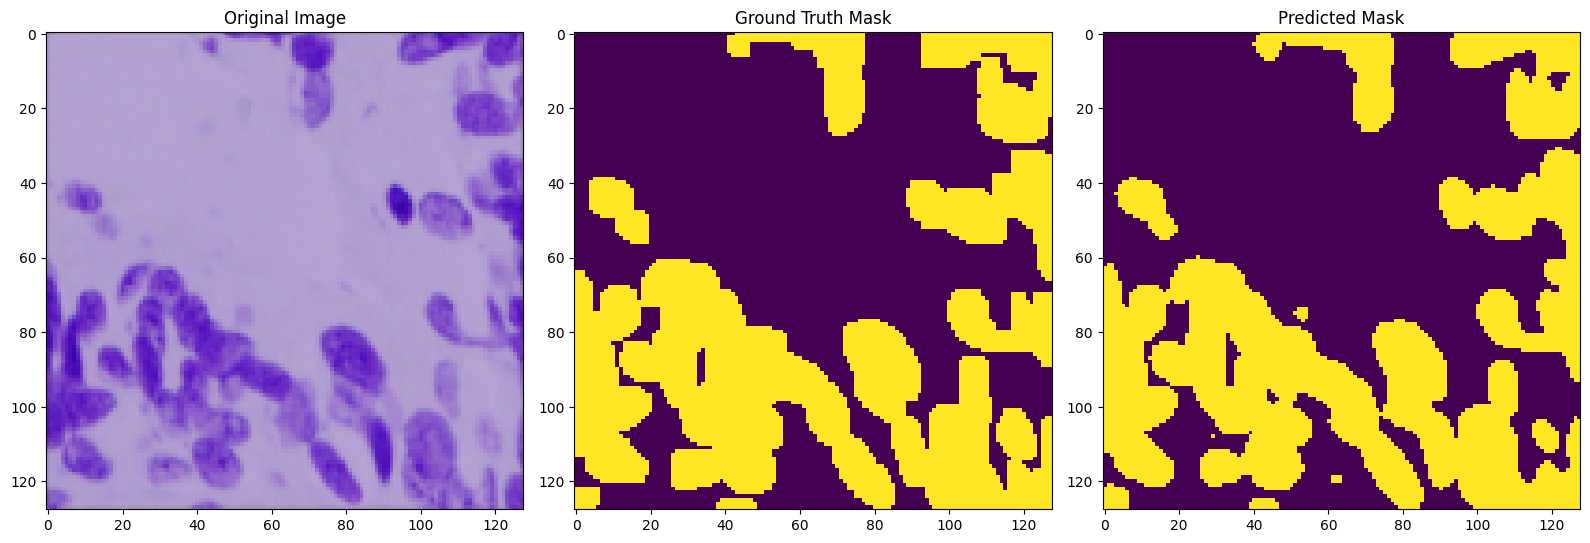

In [59]:
def display_random_sample(X_data, Y_data, predictions):
    """
    Display a random sample consisting of the original image, ground truth mask, and predicted mask.

    Parameters:
    - X_data: Array of original images.
    - Y_data: Array of ground truth masks.
    - predictions: Array of predicted masks by the model.

    The function randomly selects an image from the dataset, displays the original image,
    the actual mask (ground truth), and the mask predicted by the model. This visual comparison
    helps in understanding the model's segmentation accuracy on a qualitative level.
    """
    # Randomly select an index from the dataset
    ix = random.randint(0, len(predictions) - 1)

    # Plot original image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(1, 3, figsize=(16, 8))
    ax[0].imshow(X_data[ix])
    ax[0].title.set_text('Original Image')

    ax[1].imshow(np.squeeze(Y_data[ix]))
    ax[1].title.set_text('Ground Truth Mask')

    ax[2].imshow(np.squeeze(predictions[ix]))
    ax[2].title.set_text('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Display random training sample
import random
print("Random Training Sample:")
display_random_sample(X_train, Y_train, preds_train_t)

## Model Training History Analysis

This section focuses on extracting and analyzing the training history of the model. The key metrics like loss and accuracy for both the training and validation sets are reviewed.


In [60]:
# Extracting loss values for training and validation sets
loss = results.history['loss']                      # Training loss
val_loss = results.history['val_loss']              # Validation loss

# Extracting accuracy values for training and validation sets
accuracy = results.history.get('accuracy')          # Training accuracy
val_accuracy = results.history.get('val_accuracy')  # Validation accuracy

In [61]:
print("Training Loss: ", loss[-1])
print("Validation Loss: ", val_loss[-1])
print("Training Accuracy: ", accuracy[-1])
print("Validation Accuracy: ", val_accuracy[-1])

Training Loss:  0.08848016709089279
Validation Loss:  0.09331854432821274
Training Accuracy:  0.9661301374435425
Validation Accuracy:  0.9628869891166687


## Visualization of Training and Validation Metrics



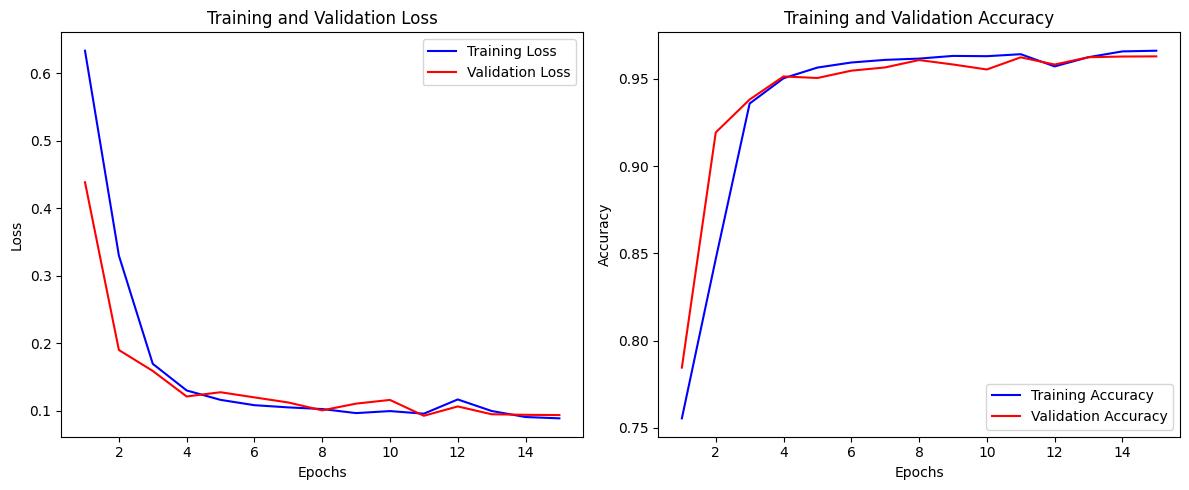

In [62]:
# Number of epochs - determines the X-axis in the plots
epochs = range(1, len(loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values (if available)
if accuracy is not None and val_accuracy is not None:
    # Subplot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()